### Создание генеративной состязательной сети (GAN). Будем использовать PyTorch. GAN для генерации изображений.


In [2]:
!pip install torch torchvision matplotlib

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/203.0 MB 5.7 MB/s eta 0:00:36
   ---------------------------------------- 2.1/203.0 MB 6.2 MB/s eta 0:00:33
    --------------------------------------- 3.9/203.0 MB 7.3 MB/s eta 0:00:28
   - -------------------------------------- 5.5/203.0 MB 7.5 MB/s eta 0:00:27
   - -------------------------------------- 6.8/203.0 MB 7.0 MB/s eta 0:00:29
   - -------------------------------------- 8.4/203.0 MB 7.1 MB/s eta 0:00:28
   -- ------------------------------------- 10.2/203.0 MB 7.4 MB/s eta 0:00:26
   -- ------------------------------------- 11.8/203.0 MB 7.5 MB/s eta 0:00:26
   -- ------------------------------------- 13


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Цикл обучения, используя данные CIFAR-10

Files already downloaded and verified
Epoch [1/100], d_loss: 0.0678, g_loss: 4.5662
Epoch [2/100], d_loss: 0.0788, g_loss: 6.2983
Epoch [3/100], d_loss: 0.2780, g_loss: 2.9356
Epoch [4/100], d_loss: 0.1225, g_loss: 6.1537
Epoch [5/100], d_loss: 0.3061, g_loss: 5.5842
Epoch [6/100], d_loss: 0.3638, g_loss: 6.1527
Epoch [7/100], d_loss: 0.8647, g_loss: 3.3655
Epoch [8/100], d_loss: 0.3317, g_loss: 2.7993
Epoch [9/100], d_loss: 0.7188, g_loss: 3.3110
Epoch [10/100], d_loss: 0.5617, g_loss: 3.6310
Epoch [11/100], d_loss: 0.4430, g_loss: 3.2779
Epoch [12/100], d_loss: 1.0544, g_loss: 3.3600
Epoch [13/100], d_loss: 0.5491, g_loss: 3.7138
Epoch [14/100], d_loss: 0.5695, g_loss: 2.6304
Epoch [15/100], d_loss: 1.0183, g_loss: 2.7203
Epoch [16/100], d_loss: 0.6484, g_loss: 2.5585
Epoch [17/100], d_loss: 1.2206, g_loss: 2.3181
Epoch [18/100], d_loss: 1.1073, g_loss: 2.4936
Epoch [19/100], d_loss: 1.0530, g_loss: 2.0060
Epoch [20/100], d_loss: 1.1341, g_loss: 2.4278
Epoch [21/100], d_loss: 1.1169,

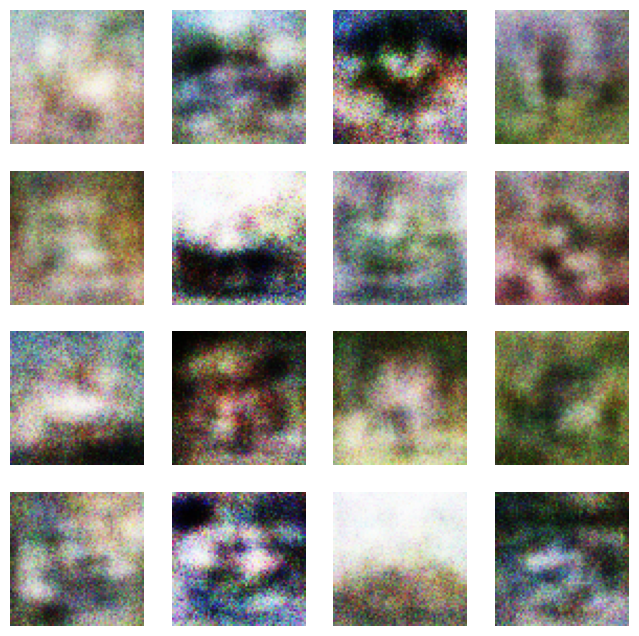

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Преобразования данных
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасета
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Определение генератора
class Generator(nn.Module):
    def __init__(self, z_dim=100):  # z_dim соответствует размерности шума
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * 64 * 64),
            nn.Tanh()  # Выходной слой с Tanh для нормализации изображений
        )

    def forward(self, z):
        z = self.model(z)
        return z.view(-1, 3, 64, 64)  # Изменение формы для изображений

# Определение дискриминатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.view(-1, 3 * 64 * 64)  # Изменение формы для входа
        return self.model(x)

# Инициализация моделей
z_dim = 100  # Определяем размерность шума
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Оптимизаторы
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Функция потерь
criterion = nn.BCEWithLogitsLoss()

# Обучение GAN
num_epochs = 100
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Обновление дискриминатора
        optimizer_D.zero_grad()
        real_labels = torch.ones(images.size(0), 1).to(device)
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(images.size(0), z_dim).to(device)  # Случайный шум
        fake_images = generator(z)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Обновление генератора
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

# Генерация фейковых изображений для проверки
with torch.no_grad():
    z = torch.randn(16, z_dim).to(device)  # размерность совпадает
    fake_images = generator(z)

# Отображение изображений
fake_images = fake_images.cpu().numpy()
fake_images = (fake_images + 1) / 2  # Обратное преобразование для отображения

# Отображение 4x4 сетки изображений
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(fake_images[i].transpose(1, 2, 0))  # Изменение порядка осей
    ax.axis('off')  # Скрыть оси
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [02:11<00:00, 1.29MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


C:\Users\user\AppData\Local\Temp\ipykernel_16220\1977669293.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Для смешанной точности
D:\GItHUB\DS_ls1\venv\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_16220\1977669293.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
D:\GItHUB\DS_ls1\venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_16220\1977669293.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('

Epoch [10/50], d_loss: 0.7327, g_loss: 3.4476
Epoch [20/50], d_loss: 1.2688, g_loss: 1.8484
Epoch [30/50], d_loss: 1.5877, g_loss: 1.2961
Epoch [40/50], d_loss: 1.0721, g_loss: 1.2037
Epoch [50/50], d_loss: 1.3192, g_loss: 1.0360


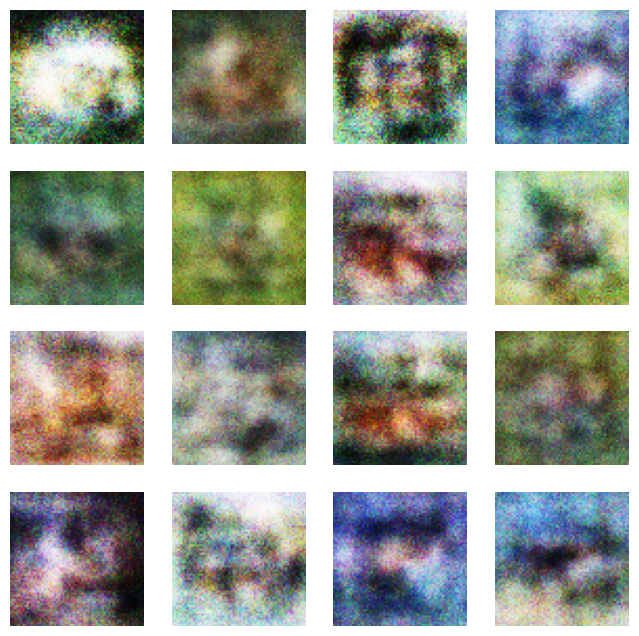

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Преобразования данных
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасета
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Определение генератора
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 64),  # Уменьшено с 128 до 64
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.model(z)
        return z.view(-1, 3, 64, 64)

# Определение дискриминатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.view(-1, 3 * 64 * 64)
        return self.model(x)

# Инициализация моделей
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Оптимизаторы
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Функция потерь
criterion = nn.BCEWithLogitsLoss()

# Обучение GAN
num_epochs = 50  # Уменьшено количество эпох
scaler = torch.cuda.amp.GradScaler()  # Для смешанной точности

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Обновление дискриминатора
        optimizer_D.zero_grad()
        real_labels = torch.ones(images.size(0), 1).to(device)

        with torch.cuda.amp.autocast():
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(images.size(0), z_dim).to(device)
            fake_images = generator(z)
            fake_labels = torch.zeros(images.size(0), 1).to(device)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake

        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Обновление генератора
        optimizer_G.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

    if (epoch + 1) % 10 == 0:  # Печать каждые 10 эпох
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

# Генерация фейковых изображений для проверки
with torch.no_grad():
    z = torch.randn(16, z_dim).to(device)
    fake_images = generator(z)

# Отображение изображений
fake_images = fake_images.cpu().numpy()
fake_images = (fake_images + 1) / 2  # Обратное преобразование для отображения

# Отображение 4x4 сетки изображений
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(fake_images[i].transpose(1, 2, 0))  # Изменение порядка осей
    ax.axis('off')  # Скрыть оси
plt.show()